In [1]:
#file used to test scripts
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import numpy as np
import mlflow
from scipy.ndimage import zoom

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset, CompletedPassesDataset, FailedPassesDataset
from unxpass.components import pass_selection, pass_value, pass_success, pass_value_custom
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.ratings_custom import LocationPredictions

from matplotlib.backends.backend_pdf import PdfPages

from notebooks import playVisualizers
model_pass_value = pass_value.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        'runs:/20e7d3695d7049d0a513922d32b44a11/model', map_location='cpu'
        #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    ), offensive = False
)
DATA_DIR = Path("../stores/")
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/buli_all.sql"
feat_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fail"
db = SQLiteDatabase(dbpath)
dataset_test = partial(PassesDataset, path = feat_path)
#surfaces = model_pass_value.predict_surface(dataset_test, db = db, model_name = "val", game_id = game_id)

/home/lz80/un-xPass/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
import regex as re
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
def json_player_to_df(filepath):
    player_df_all = pd.read_json(filepath, lines = True, orient = 'columns')
    player_dict = player_df_all['samples'].loc[0]['people']
    player_df = pd.DataFrame(player_dict)#['centroid'].loc[0][0]
    player_df['time'] = player_df.apply(lambda d: d['centroid'][0]['time'], axis = 1)
    player_df['uefaID'] = player_df.apply(lambda d: d['personId']['uefaId'], axis = 1)
    player_df['position'] = player_df.apply(lambda d: d['centroid'][0]['pos'], axis = 1)
    player_df['role'] = player_df.apply(lambda d: d['role']['name'], axis = 1)
    player_df = player_df[(player_df['role'] == "Goalkeeper") | (player_df['role'] == "Outfielder")]
    filename = filepath.split("/")[-1]
    filesplit = re.split("\_|\.",filename)
    period = filesplit[3]
    minute = filesplit[4]
    if len(filesplit) == 8:
        added_time = 0
    else:
        added_time = filesplit[5]
    #player_df = player_df.sort_values(by = ['time'])
    player_df["period"] = int(period)
    player_df['minute'] = int(minute)
    player_df['added_time'] = int(added_time)
    return player_df[['time', 'uefaID','position', "period", "minute", "added_time", 'role']]

In [ ]:
#get speeds from hawkeye for a certain player
base_filepath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032206_England_Austria"
player = "1908151"
player_filepath = f"{base_filepath}/scrubbed.samples.centroids"
all_files = []
iter = 1
for filename in os.listdir(player_filepath):
    print(f"Processing {filename}, {iter}/{len(os.listdir(player_filepath))}", end = "\r")
    testfile = f"{player_filepath}/{filename}"
    player_df = json_player_to_df(testfile)
    all_files.append(player_df)
    iter += 1
#case of one player
allpos = pd.concat(all_files)

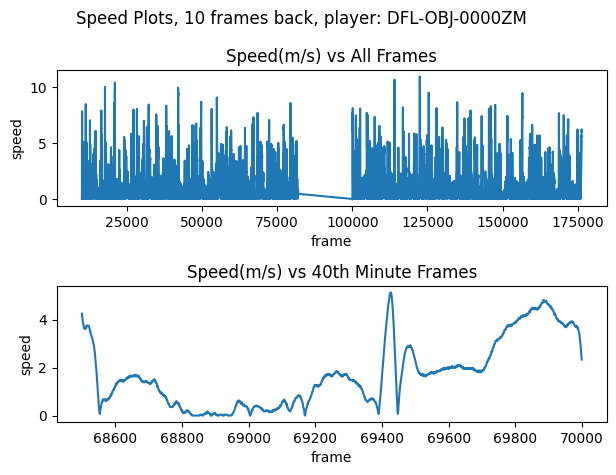

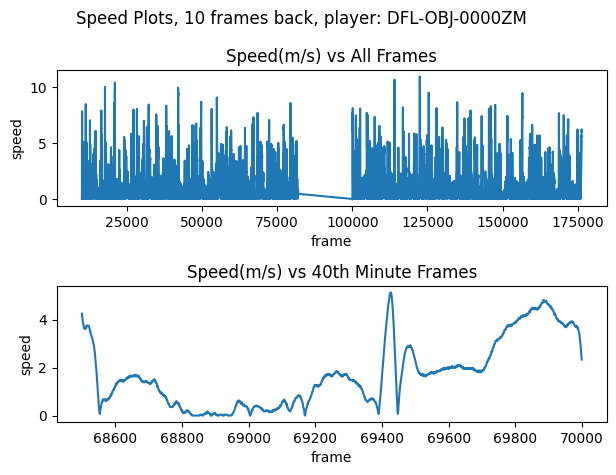

In [82]:
def generateSpeedPlots(playerdf, framesback):
    playerpos = playerdf.copy()
    first_min = {2:46, 3:91, 4: 106}
    playerpos['prev_pos'] = playerpos['position'].shift(framesback)
    playerpos['prev_pos'] = playerpos['prev_pos'].fillna(playerpos['position'])
    playerpos['current_fulltime'] = playerpos['time'] + 60 * (playerpos['minute'] + playerpos['added_time'])
    playerpos['prev_time'] = playerpos['current_fulltime'].shift(framesback)
    playerpos['position'] = playerpos['position'].apply(lambda pos: np.array(eval(pos)) if isinstance(pos, str) else np.array(pos))
    playerpos['prev_pos'] = playerpos['prev_pos'].apply(lambda pos: np.array(eval(pos)) if isinstance(pos, str) else np.array(pos))
    def compute_speed(row):
        if row['prev_time'] is None or row['current_fulltime'] == row['prev_time']:
            return 0  # Avoid division by zero
        return distance.euclidean(row['position'], row['prev_pos']) / (row['current_fulltime'] - row['prev_time'])

    playerpos['speed'] = playerpos.apply(compute_speed, axis=1)
    playerpos['speed'] = playerpos['speed'].fillna(0)
    for period in range(1, max(playerpos['period'])):
        minute = first_min[period + 1]
        time = 0
        mask = (playerpos['time'] == time) & (playerpos['minute'] == minute) & (playerpos['period'] == period + 1)
        playerpos.loc[mask, "speed"] = 0
    playerpos = playerpos.reset_index(drop = True)
    fig, axs = plt.subplots(2,1)
    if len(playerpos['role'].iloc[0]) > 0:
        title = f"Speed Plots, {framesback} frames back, player: {playerpos['uefaID'].iloc[0]}, position: {playerpos['role'].iloc[0]}"
    else:
         title = f"Speed Plots, {framesback} frames back, player: {playerpos['uefaID'].iloc[0]}"
    fig.suptitle(title)
    sns.lineplot(data=playerpos, x="frame", y="speed", ax=axs[0])
    axs[0].set(title = "Speed(m/s) vs All Frames")
    sns.lineplot(data=playerpos[playerpos['minute'] == 40], x="frame", y="speed", ax=axs[1])
    axs[1].set(title = "Speed(m/s) vs 40th Minute Frames")
    
    plt.tight_layout()
    return fig
#sns.lineplot(data=playerpos[playerpos['time'].isin(playerpos['time'].unique()[::700])], x="frame", y="speed", ax=axs[2])
#axs[2].set(title = "speed vs every 5th frame")

generateSpeedPlots(playerdf, 10)

In [19]:
pdf_filename = "all_players_speed_plots.pdf"
allpos = allpos.sort_values(by = ["period", "minute", "added_time", "time"])
allpos['frame'] = allpos.groupby(['period', 'minute', 'added_time', 'time']).ngroup()
idx = 1
with PdfPages(pdf_filename) as pdf:
    for player in allpos['uefaID'].unique():
        print(f"Iterating player {player}, {idx}/{len(allpos['uefaID'].unique())}", end = "\r",)
        idx += 1
        playerpos = allpos[allpos['uefaID'] == player]
        fig = generateSpeedPlots(playerpos, framesback=10)
        pdf.savefig(fig, bbox_inches="tight")  # Save figure to PDF
        plt.close(fig) 


In [81]:
from unxpass import load_xml
def plotBuLiSpeeds(game_id, framesback):
    
    trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml")
    trackingdf['frame'] = trackingdf['N'].astype(int)
    trackingdf['X'] = trackingdf['X'].astype(float)
    trackingdf['Y'] = trackingdf['X'].astype(float)
    trackingdf = trackingdf.sort_values(by = "N")
    inithalfs = trackingdf.drop_duplicates('GameSection')[['GameSection', "T"]]
    inithalfs['period'] = range(1, inithalfs.shape[0] + 1)
    trackingdf = pd.merge(trackingdf, inithalfs, on = "GameSection")
    half_dict = {1:0, 2:45, 3:90, 4:105}
    trackingdf['totaltime'] = (pd.to_datetime(trackingdf['T_x']) - pd.to_datetime(trackingdf['T_y'])).dt.total_seconds()
    trackingdf['minute'] = trackingdf['period'].map(half_dict) + trackingdf['totaltime'] // 60 + 1
    trackingdf['time'] = trackingdf['totaltime'] % 60 #this is kinda dumb but ig its better to reuse old functions
    trackingdf['added_time'] = 0#just a dummy
    trackingdf['position'] = trackingdf[['X','Y']].values.tolist()
    trackingdf['uefaID'] = trackingdf['PersonId']#also stupid but whatevs, not actual uefaID
    trackingdf['role'] = ""
    trackingdf_clean = trackingdf[["uefaID", "frame", "position", "period", "totaltime", "minute", "time", "added_time", "role"]]
    playerdf = trackingdf_clean[trackingdf_clean['uefaID'] == "DFL-OBJ-0000ZM"]
    

,uefaID,frame,position,period,totaltime,minute,time,added_time,role
0,DFL-OBJ-0000ZM,10000,"[-0.56, -0.56]",1,0.00,1.0,0.00,0,
43,DFL-OBJ-0000ZM,10001,"[-0.63, -0.63]",1,0.04,1.0,0.04,0,
49,DFL-OBJ-0000ZM,10002,"[-0.72, -0.72]",1,0.08,1.0,0.08,0,
71,DFL-OBJ-0000ZM,10003,"[-0.82, -0.82]",1,0.12,1.0,0.12,0,
99,DFL-OBJ-0000ZM,10004,"[-0.91, -0.91]",1,0.16,1.0,0.16,0,
...,...,...,...,...,...,...,...,...,...
3410238,DFL-OBJ-0000ZM,176307,"[-1.12, -1.12]",2,3052.28,96.0,52.28,0,
3410260,DFL-OBJ-0000ZM,176308,"[-1.3, -1.3]",2,3052.32,96.0,52.32,0,
3410286,DFL-OBJ-0000ZM,176309,"[-1.47, -1.47]",2,3052.36,96.0,52.36,0,
3410312,DFL-OBJ-0000ZM,176310,"[-1.63, -1.63]",2,3052.40,96.0,52.40,0,


KeyError: 'role'

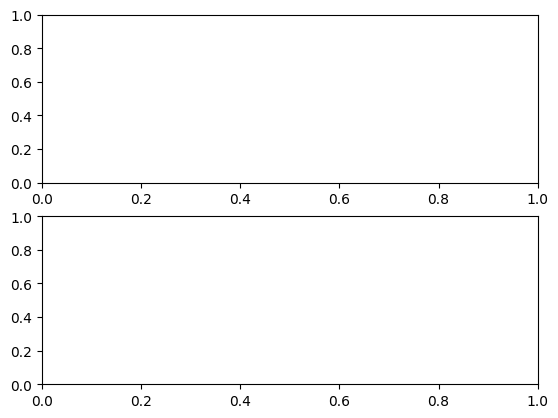

In [ ]:
def savetopdf(pdf_filename, allpos):
    with PdfPages(pdf_filename) as pdf:
        for player in allpos['uefaID'].unique():
            print(f"Iterating player {player}, {idx}/{len(allpos['uefaID'].unique())}", end = "\r",)
            idx += 1
            playerpos = allpos[allpos['uefaID'] == player]
            fig = generateSpeedPlots(playerpos, framesback=framesback)
            pdf.savefig(fig, bbox_inches="tight")  # Save figure to PDF
            plt.close(fig) 

In [5]:
def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too

In [6]:
ptt, gk = getGksTM("3835324")

In [ ]:
path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032218_Netherlands_Sweden/scrubbed.samples.centroids/2021_18_2032218_1_2.football.samples.centroids"
player_df_all = pd.read_json(path, lines = True, orient = 'columns')
player_dict = player_df_all['samples'].loc[0]['people']
player_df = pd.DataFrame(player_dict)#['centroid'].loc[0][0]
player_df['time'] = player_df.apply(lambda d: d['centroid'][0]['time'], axis = 1)
player_df = player_df.sort_values(by = ['time'])
second_range = [12.014744999999996, 12.424744999999996]
second = second_range[0]
if len(second_range) == 1:
    max_second = second + 1
else:
    max_second = second_range[1]
if second > max_second:
    second = 0
player_df = player_df[(player_df['time'] >= second) & (player_df['time'] <= max_second)]
minute = 10
print(path)
player_df['minute'] = minute
player_df['pos'] = player_df.apply(lambda d: d['centroid'][0]['pos'], axis = 1)
player_df['pos_name'] = player_df.apply(lambda d: d['role']['name'], axis = 1)
player_df = player_df[(player_df['pos_name'] == "Goalkeeper") | (player_df['pos_name'] == "Outfielder")]
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
uefa_map = dict(zip(sequences['uefa_player_id'], sequences['player_id']))
player_df['statsbombid'] = player_df.apply(lambda d: d['personId']['uefaId'], axis = 1).astype(int).map(uefa_map)
#no data on this certain gk
#player_df[player_df.isnull().any(axis=1)].iloc[0]['personId']#missing '250040883'
#maybe get count of each team to figure out who is missing and fill rest
player_df['team'] = player_df['statsbombid'].map(ptt)
val_counts = player_df['team'].value_counts()
min(player_df['team'].value_counts()), player_df['team'].value_counts()

/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032218_Netherlands_Sweden/scrubbed.samples.centroids/2021_18_2032218_1_2.football.samples.centroids


(110,
 858.0    121
 851.0    110
 Name: team, dtype: int64)

In [20]:
player_df

,centroid,personId,role,trackId,time,minute,pos,pos_name,statsbombid,team
7524,"[{'speed': {'mph': 3.345261528226876, 'mps': 1...",{'heId': '93057332-4814-43f0-096b-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13390,12.014781,10,"[-25.576663978061678, -28.812214769564708]",Outfielder,10215.0,858.0
7514,"[{'speed': {'mph': 0.919065704212444, 'mps': 0...",{'heId': '7b6d76c3-da0d-43c5-0844-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13392,12.014781,10,"[-12.932564090133885, -29.064456049649817]",Outfielder,10222.0,858.0
7515,"[{'speed': {'mph': 6.523491806804425, 'mps': 2...",{'heId': 'd5f456bf-2e66-4c01-bc99-08da5df3bc86...,"{'id': 1, 'name': 'Outfielder'}",13456,12.014781,10,"[-34.209345333640876, -24.214846964080845]",Outfielder,10647.0,851.0
7516,"[{'speed': {'mph': 2.164190581309226, 'mps': 0...",{'heId': '0996b697-0ab7-4a25-085b-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13462,12.014781,10,"[-25.794412754586336, 4.252431562127221]",Outfielder,10666.0,851.0
7517,"[{'speed': {'mph': 2.014015735935652, 'mps': 0...",{'heId': '5791e8a9-6f31-4fcb-bc9c-08da5df3bc86...,"{'id': 1, 'name': 'Outfielder'}",13474,12.014781,10,"[-21.79285913981281, -9.08639653481694]",Outfielder,10645.0,851.0
...,...,...,...,...,...,...,...,...,...,...
7761,"[{'speed': {'mph': 0.256223084240504, 'mps': 0...",{'heId': 'c68e2dac-3632-4f6a-0840-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13410,12.414745,10,"[1.272004483792198, -24.772683814836927]",Outfielder,4633.0,858.0
7756,"[{'speed': {'mph': 0.287588307514419, 'mps': 0...",{'heId': '96d5d1e9-69c3-45a7-bc95-08da5df3bc86...,"{'id': 1, 'name': 'Outfielder'}",13372,12.414745,10,"[-12.18994282762496, -12.41723981466418]",Outfielder,62666.0,858.0
7757,"[{'speed': {'mph': 2.6963078900965023, 'mps': ...",{'heId': '9420d57f-6716-413e-0855-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13382,12.414745,10,"[-27.21597521973469, -31.360557538790374]",Outfielder,32333.0,851.0
7758,"[{'speed': {'mph': 1.434562685779822, 'mps': 0...",{'heId': '14c8d9b4-cde7-45b0-0c41-08da07525cdf...,"{'id': 1, 'name': 'Outfielder'}",13384,12.414745,10,"[-23.96794208732439, -11.90987766646227]",Outfielder,10220.0,858.0


In [48]:
def getFlips(game_id):
    events = load_xml.load_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/event_data_all/{game_id}.xml")
    events[['TeamLeft', 'TeamRight']] = events[['TeamLeft', 'TeamRight']].fillna(method='ffill')
    #direction of play to right
    #if team in possession is team left - all good
    #if team in possession is team right - need to flip
    return events.loc[events['Team'] == events['TeamRight'], 'EventId']
def frametodict(group, shouldFlip):
    """
    Converts a group of tracking data into a dictionary with player IDs as keys and their translated positions.
    """
    # Exclude the BALL rows and work on a copy to avoid SettingWithCopyWarning
    noball = group[group['TeamId'] != "BALL"].copy()

    # Ensure numeric conversion for X and Y (if not already floats)
    noball['X'] = noball['X'].astype(float)
    noball['Y'] = noball['Y'].astype(float)
    
    # Compute translated coordinates using vectorized operations
    noball['X_translated'] = 120 - (1.09361 * noball['X'] + 60)
    noball['Y_translated'] = 80 - (-1.09361 * noball['Y'] + 40)
    
    # Apply flip if necessary
    if shouldFlip:
        noball['X_translated'] = 120 - noball['X_translated']
        noball['Y_translated'] = 80 - noball['Y_translated']
    
    # Build the dictionary using itertuples for faster iteration
    locs = {
        row.PersonId: {"X": row.X_translated, "Y": row.Y_translated, "Team": row.TeamId}
        for row in noball.itertuples(index=False)
    }
    
    return locs


In [65]:
#getting speeds from n prior frames for buli data
from unxpass import load_xml
#load all relevant data
def getSpeedBuli(game_id, action_id, tracking_groups, eventcsv, id_to_event, flips, framesback = 10):
    timediff = 0.04 * framesback
    buli_id = id_to_event[(game_id, action_id)]
    shouldflip = buli_id in flips
    
    event = eventcsv[eventcsv['EVENT_ID'] == int(buli_id.split(".")[0])].iloc[0]
    event_frame = event['FRAME_NUMBER']
    team = event["CUID1"]
    event_frame_str = str(event_frame)
    prior_frame_str = str(event_frame - framesback)
    try:
        event_pos = tracking_groups.get_group(event_frame_str)
    except KeyError:
        event_pos = pd.DataFrame()
    try:
        prior_pos = tracking_groups.get_group(prior_frame_str)
    except KeyError:
        prior_pos = pd.DataFrame()
    if len(event_pos) > 0:
        event_pos = frametodict(event_pos, shouldflip)
    if len(prior_pos) > 0:
        prior_pos = frametodict(prior_pos, shouldflip)
    #return event_pos, prior_pos
    speed_output = []
    for player, pos in event_pos.items():
        isTeammate = event_pos[player]["Team"] == team
        prior = prior_pos.get(player)
        if player not in prior_pos:
            x_diff = 0
            y_diff = 0
        else:
            x_diff = event_pos[player]["X"] - prior_pos[player]["X"]
            y_diff = event_pos[player]["Y"] - prior_pos[player]["Y"]
        x_velo = x_diff / timediff
        y_velo = y_diff / timediff
        player_dict = {
            "player": player,
            "isTeammate": isTeammate,
            "x_velo": x_velo,
            "y_velo": y_velo,
            "location": [event_pos[player]["X"], event_pos[player]["Y"]],
        }
        speed_output.append(player_dict)
    return speed_output
    #need is teammate, location, and speed 

In [ ]:
import timeit
skeleton = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_endlocation.parquet")
def addAllSpeedBuli(skeleton, db):
    games = skeleton.index.get_level_values(0).unique()
    output = pd.DataFrame(index = skeleton.index)
    output["freeze_frame_360_a0"] = np.nan
    output["freeze_frame_360_a0"] = output["freeze_frame_360_a0"].astype(object)
    for game_id in games[0:1]:
        id_to_event = db.actions(game_id = game_id)['original_event_id'].to_dict()
        eventcsv = load_xml.load_csv_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/KPI_Merged_all/KPI_MGD_{game_id}.csv")
        trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml")
        tracking_groups = trackingdf.groupby('N')
        game_mask = skeleton.index.get_level_values(0) == game_id
        flips = getFlips(game_id)
        for game_id, action_id in skeleton.index[game_mask]:
            print(game_id, action_id)
            output.at[(game_id, action_id), "freeze_frame_360_a0"] = [getSpeedBuli(game_id, action_id, tracking_groups, eventcsv, id_to_event, flips = flips)]
addAllSpeedBuli(skeleton)


In [38]:
matches_map = {}
#creates map of hawkeye game ids and statsbomb game ids
from os import listdir
game_dir = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkEye/"
games = pd.read_json("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/matches/53/106.json", convert_dates = False)#directory of statsbomb matches data
games['home_team'] = games.apply(lambda d: d['home_team']['home_team_name'], axis = 1).str.replace("Women's", "").str.replace("WNT", "").str.strip()
games['away_team'] = games.apply(lambda d: d['away_team']['away_team_name'], axis = 1).str.replace("Women's", "").str.replace("WNT", "").str.strip()
dirfiles = [f for f in listdir(game_dir) if not f.startswith('.')]
for game in dirfiles:
    home_team = game.split('_')[1]
    away_team = game.split('_')[2]
    #print(games['away_team'])
    game_id = games[(games['home_team'] == home_team) & (games['away_team'] == away_team)].reset_index().loc[0]['match_id']
    matches_map[game] = int(game_id)
import json 
outpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json"
with open(outpath, "w") as f:
    json.dump(matches_map, f)

In [2]:
def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too
def clean_dict(freeze_frame):
    output = {}
    for player in freeze_frame:
        player_dict = {}
        player_dict['teammate'] = player['teammate']
        player_dict['x'] = player['location'][0]
        player_dict['y'] = player['location'][1]
        output[player['player']] = player_dict
    return output
def getSpeedsHawkeye(init, event, timediff):
    output = []
    for player in event:
        player_dict = {}
        if player not in init:
            continue
        x_diff = event[player]['x'] - init[player]['x']
        y_diff = event[player]['y'] - init[player]['y']
        x_velo = x_diff / timediff
        y_velo = y_diff / timediff
        player_dict['player'] = player
        player_dict['teammate'] = event[player]['teammate']
        player_dict['x_velo'] = x_velo
        player_dict['y_velo'] = y_velo
        player_dict['location'] = [event[player]['x'], event[player]['y']]
        output.append(player_dict)
    return output

In [3]:
#TODO: do same for hawkeye
import json
import os
import conversions
import pandas as pd
import numpy as np
from unxpass.databases import SQLiteDatabase
#might have to lookout for added events
def getSpeedHawkeye(match_id, action_id, tracking, player_to_team, goalkeepers, id_to_event):
    full_id = id_to_event[(str(match_id), action_id)]
    if len(full_id.split("-")) != 6:
        return {"empty": "empty"}
    real_id = full_id.rsplit("-", 1)[0]
    frame_idx = int(full_id.rsplit("-",1)[1])
    pass_data = sequences[sequences['id'] == real_id].iloc[0]
    timeback = 0.4
    time = pass_data['BallReceipt']
    period = pass_data['period']
    minute = int((time + .04 * int(frame_idx)) / 60 + 1)
    second = int((time + .04 * int(frame_idx)) % 60)
    second_range = (second - timeback, second + .01)
    team = pass_data['team_id']
    actor =  pass_data['player_id']
    uefa_map = {}
    file_path_begin = os.listdir(tracking)[0].rsplit("_", 2)[0]
    #goalkeepers = []
    file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute)}.football.samples.centroids"
    all_locs = []
    loc1 = conversions.read_Hawkeye_player_loc(file_path, period, minute, second_range, team,actor, real_id, player_to_team, goalkeepers)
    all_locs.append(loc1)
    if(second - timeback < 0):
        #if the time is negative, we need to get the last frame of the previous minute
        #print("Getting last frame of previous minute")
        file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute - 1)}.football.samples.centroids"
        second_range = (59 + second - timeback, 60)
        loc2 = conversions.read_Hawkeye_player_loc(file_path, period, minute - 1, second_range, team,actor, real_id, player_to_team, goalkeepers)
        all_locs.append(loc2)
    addedtracking = pd.concat(all_locs)
    addedtracking['event_uuid'] = [f"{real_id}-b{i}" for i in range(len(addedtracking), 0, -1)]
    last = clean_dict(addedtracking.loc[0]["freeze_frame"])
    first = clean_dict(addedtracking.loc[len(addedtracking) - 1]["freeze_frame"])
    return getSpeedsHawkeye(first, last, timeback)
def getAllHawkeyeSpeeds(skeleton, hawkeye_db):
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)
    output = pd.DataFrame(index = skeleton.index)
    output["speed_frame_360_a0"] = np.nan
    output["speed_frame_360_a0"] = output["speed_frame_360_a0"].astype(object)
    sb_to_hawkeye = {v: k for k, v in hawkeye_to_sb.items()}
    for match_id in skeleton.index.get_level_values(0).unique():
        hawkeye_id = sb_to_hawkeye[int(match_id)]
        sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
        tracking = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/{hawkeye_id}/scrubbed.samples.centroids"
        
        output["speed_frame_360_a0"] = {}
        id_to_event = hawkeye_db.actions(game_id = match_id)['original_event_id'].to_dict()
        player_to_team, goalkeepers = getGksTM(match_id)
        game_mask = skeleton.index.get_level_values(0) == match_id
        for game_id, action_id in skeleton.index[game_mask]:
            print(game_id, action_id)
            #get player to team mapping
            output.at[(game_id, action_id), "speed_frame_360_a0"] = [getSpeedHawkeye(game_id, action_id, tracking, player_to_team, goalkeepers, id_to_event)]
        return output
#getAllHawkeyeSpeeds(match_id, hawkeye_db)
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
skeleton = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2/x_endlocation.parquet")
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_all.sql"
hawkeye_db = SQLiteDatabase(dbpath)
getAllHawkeyeSpeeds(skeleton, hawkeye_db)


/tmp/ipykernel_202867/3747731500.py:55: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output["speed_frame_360_a0"] = {}


3835331 0
3835331 3
3835331 6
3835331 9
3835331 12
3835331 15
3835331 18
3835331 20
3835331 21
3835331 26
3835331 27
3835331 32
3835331 34
3835331 35
3835331 37
3835331 38
3835331 39
3835331 40
3835331 43
3835331 44
3835331 46
3835331 48
3835331 50
3835331 52
3835331 54
3835331 56
3835331 58
3835331 60
3835331 62
3835331 64
3835331 66
3835331 68
3835331 70
3835331 72
3835331 74
3835331 76
3835331 78
3835331 80
3835331 82
3835331 84
3835331 86
3835331 88
3835331 90
3835331 92
3835331 94
3835331 96
3835331 98
3835331 101
3835331 104
3835331 106
3835331 108
3835331 110
3835331 112
3835331 114
3835331 116
3835331 118
3835331 120
3835331 122


KeyboardInterrupt: 

In [21]:
test['freeze_frame_360'].iloc[3]

[{'teammate': True,
  'actor': False,
  'keeper': False,
  'x': 53.9109410084875,
  'y': 23.04251877462},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'x': 60.7333393592625,
  'y': 62.49992861538},
 {'teammate': False,
  'actor': False,
  'keeper': False,
  'x': 44.9381080771875,
  'y': 42.816302007395},
 {'teammate': True,
  'actor': True,
  'keeper': False,
  'x': 65.1053240112625,
  'y': 54.07268605671},
 {'teammate': False,
  'actor': False,
  'keeper': False,
  'x': 60.412700664662495,
  'y': 59.03813544152},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'x': 57.7143332166625,
  'y': 51.983221759105},
 {'teammate': True,
  'actor': False,
  'keeper': True,
  'x': 94.7971210454625,
  'y': 40.5646292472},
 {'teammate': False,
  'actor': False,
  'keeper': True,
  'x': 17.512250348162496,
  'y': 44.65214084119},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'x': 52.688217561875,
  'y': 42.783402226655},
 {'teammate': True,
  'actor': False,
  '

In [ ]:
#adding dummy events prior for speeds for hawkeye data
def hawkeyeGetBefore(row):
    #the very easy efficiency change is to compute by game so we don't have to load the jsons every time for every pass
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)
    sb_to_hawkeye = {v: k for k, v in hawkeye_to_sb.items()}
    match_id = row['match_id']
    hawkeye_id = sb_to_hawkeye[match_id]

    id = row['id']
    time = row['BallReceipt']
    sb_event = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/events/{match_id}.json")
    sb_tracking = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/three-sixty/{match_id}.json")
    sb_matches = pd.read_json("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/matches/53/106.json")
    tracking = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/{hawkeye_id}/scrubbed.samples.centroids"
    out_sb_event = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_b/events/{match_id}.json"
    out_three_sixty = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_b/three-sixty/{match_id}.json"
    file_path_begin = "2021_18_2032206"#this should be different for each game
    import conversions 
    #)
    timeback = 0.1
    sequences.columns
    period = row['period']
    minute = int(time / 60) + 1
    second = int(time) % 60
    second_range = (second - timeback, second)
    team = row['team_id']
    actor = row['player_id']
    uefa_map = {}
    #goalkeepers = []
    file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute)}.football.samples.centroids"
    def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too
    player_to_team, goalkeepers = getGksTM(match_id)
    all_locs = []
    loc1 = conversions.read_Hawkeye_player_loc(file_path, period, minute, second_range, team,actor, id, player_to_team, goalkeepers)
    all_locs.append(loc1)
    if(second - timeback < 0):
        #if the time is negative, we need to get the last frame of the previous minute
        #print("Getting last frame of previous minute")
        file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute - 1)}.football.samples.centroids"
        second_range = (59 + second - timeback, 59)
        loc2 = conversions.read_Hawkeye_player_loc(file_path, period, minute - 1, second_range, team,actor, id, player_to_team, goalkeepers)
        all_locs.append(loc2)
    addedtracking = pd.concat(all_locs)
    addedtracking['event_uuid'] = [f"{id}-b{i}" for i in range(len(addedtracking), 0, -1)]
    framesback = addedtracking.shape[0]
    #conversions
    def add_events(id, framesback):
        #.04 seconds per frame
        sb_row = sb_event[sb_event['id'] == id].reset_index().loc[0]
        ogtime = sb_row['timestamp']
        framediff = pd.Timedelta(seconds = 0.04)
        added_events = pd.DataFrame([sb_row] * framesback)
        added_events['id'] = [f"{id}-b{i}" for i in range(framesback, 0, -1)]
        added_events['timestamp'] = [ogtime - i for i in [j * framediff for j in range(1, framesback + 1)]]
        added_events['index'] = [row['index'] - 1 + i * (1 / (framesback + 1)) for i in range(1, framesback + 1)]
        return added_events
    added_events = add_events(id, framesback)
    eventsadded = pd.concat([sb_event, added_events])
    threesixtyadded = pd.concat([sb_tracking, addedtracking])
    threesixtyadded.to_json(out_three_sixty, orient = "records", lines = True)
    eventsadded.to_json(out_sb_event, orient = "records", lines = True)
    return added_events, addedtracking
import json
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
row = sequences.loc[0]
added_events, added_tracking = hawkeyeGetBefore(row)

In [ ]:
player_df_all = pd.read_json(file_path, lines = True, orient = 'columns')
player_dict = player_df_all['samples'].loc[0]['people']
player_df = pd.DataFrame(player_dict)
times = player_df['centroid'].apply(lambda x: x[0]['time'])
times.unique()[0] - times.unique()[1]#getting framerate

In [ ]:
game_id = 'DFL-MAT-J03YDU'
labs = model_pass_value.initialize_dataset(dataset_test, model_name = "val").labels
fails = labs[labs['concedes_xg'] > 0].index
#db.actions(game_id = game_id).loc[fails]
gameidx = [idx for idx in fails if idx[0] == game_id]
eventids = db.actions(game_id = game_id).loc[gameidx]['original_event_id']


In [48]:
from unxpass.load_xml import load_tracking, load_csv_event
from unxpass.visualizers_made import get_animation_from_raw
def get_trackingevent(game_id):
    trackingpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml"
    eventpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/KPI_Merged_all/KPI_MGD_{game_id}.csv"
    eventdf = load_csv_event(eventpath)
    trackingdf = load_tracking(trackingpath)
    return trackingdf, eventdf

trackingdf, eventdf = get_trackingevent(game_id)

In [ ]:
for event_id in eventids:
    print(event_id)

In [ ]:
itera = 1
framerate = 5
eventid = eventids[itera]
test = get_animation_from_raw(float(eventid), framerate, eventdf, trackingdf, frameskip = 20, show = False, add_frames = 600)
#eventdf[eventdf["EVENT_ID"] == float(eventid)]
#eventid


In [ ]:
test.save("file.gif")